In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score,classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
path = '../Dataset/bank_customer.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,Unnamed: 0,ID,Gender,Month_Income,Age,Region_Code,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,0,VBENBARO,Male,96345.0,29,254,Other,623,Yes,4,742366,X1,2,No
1,1,CCMEWNKY,Male,85640.0,43,268,Other,629,NaN,0,925537,X2,1,No
2,2,VK3KGA9M,Male,96345.0,31,270,Salaried,357,No,0,215949,X1,1,No
3,3,TT8RPZVC,Male,85640.0,29,272,Other,356,No,0,868070,X1,3,No
4,4,SHQZEYTZ,Female,42820.0,29,270,Other,572,No,0,657087,X1,3,No


In [4]:
#mapping the Account_Category	
category_mapping = {
    'X1': 'Savings Account',
    'X2': 'Current Account',
    'X3': 'Senior Citizens Account',
    'X4': 'Investment Account'
}

# Replace the values in the Account_Category column
df['Account_Category'] = df['Account_Category'].replace(category_mapping)

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             105000 non-null  int64  
 1   ID                     105000 non-null  object 
 2   Gender                 105000 non-null  object 
 3   Month_Income           102514 non-null  float64
 4   Age                    105000 non-null  int64  
 5   Region_Code            105000 non-null  int64  
 6   Occupation             102486 non-null  object 
 7   Credit_Score           105000 non-null  int64  
 8   Loan_Status            92511 non-null   object 
 9   Existing_Credit_Cards  105000 non-null  int64  
 10  Avg_Account_Balance    105000 non-null  int64  
 11  Account_Category       105000 non-null  object 
 12  Tenure_with_Bank       105000 non-null  int64  
 13  Lead_Outcome           105000 non-null  object 
dtypes: float64(1), int64(7), object(6)
m

In [7]:
missing_values = df.isna().sum().to_dict()

# Filter columns with missing values
columns_with_missing_values = {k: v for k, v in missing_values.items() if v > 0}

column_data_types = df.dtypes.to_dict()

numerical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] in ['int64', 'float64']}
categorical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] == 'object'}

print("Numerical columns with missing values:", numerical_missing)
print("Categorical columns with missing values:", categorical_missing)

Numerical columns with missing values: {'Month_Income': 2486}
Categorical columns with missing values: {'Occupation': 2514, 'Loan_Status': 12489}


In [8]:
print(f"Number of rows before dropping: {df.shape[0]}")

# Step 1: Drop rows with any missing values
df = df.dropna()

# Step 2: Display the number of rows after dropping
print(f"Number of rows after dropping: {df.shape[0]}")

# Optionally, check how many missing values are left (should be zero)
print(df.isnull().sum())

Number of rows before dropping: 105000
Number of rows after dropping: 88143
Unnamed: 0               0
ID                       0
Gender                   0
Month_Income             0
Age                      0
Region_Code              0
Occupation               0
Credit_Score             0
Loan_Status              0
Existing_Credit_Cards    0
Avg_Account_Balance      0
Account_Category         0
Tenure_with_Bank         0
Lead_Outcome             0
dtype: int64


In [9]:
df = df.drop(['Unnamed: 0','ID', 'Region_Code'], axis=1)

In [10]:
df.head()

,Gender,Month_Income,Age,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,Male,96345.0,29,Other,623,Yes,4,742366,Savings Account,2,No
2,Male,96345.0,31,Salaried,357,No,0,215949,Savings Account,1,No
3,Male,85640.0,29,Other,356,No,0,868070,Savings Account,3,No
4,Female,42820.0,29,Other,572,No,0,657087,Savings Account,3,No
5,Male,64230.0,60,Self_Employed,478,No,0,4624262,Senior Citizens Account,5,No


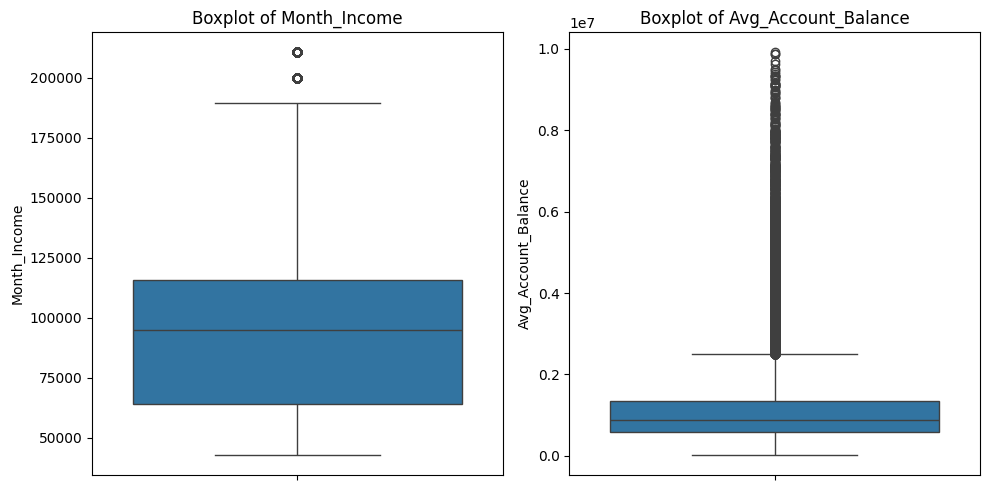

In [11]:
columns_with_outliers = ['Month_Income', 'Avg_Account_Balance']

plt.figure(figsize=(10, 5))

for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(1, len(columns_with_outliers), i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    
plt.tight_layout()
plt.show()

In [12]:
def remove_outliers_zscore(df, threshold=3):
    df_cleaned = df.copy()
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
        z_scores = (df_cleaned[column] - df_cleaned[column].mean()) / df_cleaned[column].std()
        
        outliers_condition = np.abs(z_scores) > threshold
        
        df_cleaned = df_cleaned[outliers_condition]
        
        print(f"Column: {column}")
        print(f"Removed {outliers_condition.sum()} outliers.")
        print("*" * 40)
        
    return df_cleaned

df_new = remove_outliers_zscore(df)


Column: Month_Income
Removed 0 outliers.
****************************************
Column: Age
Removed 0 outliers.
****************************************
Column: Credit_Score
Removed 0 outliers.
****************************************
Column: Existing_Credit_Cards
Removed 0 outliers.
****************************************
Column: Avg_Account_Balance
Removed 0 outliers.
****************************************
Column: Tenure_with_Bank
Removed 0 outliers.
****************************************


In [13]:
#selecting categorical columns

categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
categorical_cols

['Gender', 'Occupation', 'Loan_Status', 'Account_Category', 'Lead_Outcome']

In [14]:
#selecting numerical columns

numerical_cols = df.select_dtypes(include=['float64','int64']).columns.to_list()
numerical_cols

['Month_Income',
 'Age',
 'Credit_Score',
 'Existing_Credit_Cards',
 'Avg_Account_Balance',
 'Tenure_with_Bank']

In [15]:
for column in categorical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

        Count  Percentage
Gender                   
Male    47376   53.749021
Female  40767   46.250979
----------------------------------------
               Count  Percentage
Occupation                      
Self_Employed  34941   39.641265
Salaried       27649   31.368345
Other          24927   28.280181
Entrepreneur     626    0.710210
----------------------------------------
             Count  Percentage
Loan_Status                   
No           58530   66.403458
Yes          29613   33.596542
----------------------------------------
                         Count  Percentage
Account_Category                          
Savings Account          40986   46.499438
Current Account          22780   25.844367
Senior Citizens Account  22393   25.405307
Investment Account        1984    2.250888
----------------------------------------
              Count  Percentage
Lead_Outcome                   
No            54485   61.814324
Yes           33658   38.185676
------------------------

In [16]:
for column in numerical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

              Count  Percentage
Month_Income                   
107050.0       7872    8.930942
85640.0        7855    8.911655
74935.0        7793    8.841315
42820.0        7789    8.836777
96345.0        7749    8.791396
53525.0        7714    8.751688
64230.0        7713    8.750553
136825.0       2459    2.789785
210500.0       2446    2.775036
126300.0       2441    2.769363
147350.0       2436    2.763691
199975.0       2434    2.761422
189450.0       2417    2.742135
84200.0        2398    2.720579
105250.0       2397    2.719445
73675.0        2395    2.717175
168400.0       2393    2.714906
157875.0       2390    2.711503
178925.0       2377    2.696754
94725.0        2342    2.657046
115775.0       2333    2.646835
----------------------------------------
     Count  Percentage
Age                   
28    5905    6.699341
29    5336    6.053799
27    5228    5.931271
30    4288    4.864822
26    3631    4.119442
..     ...         ...
81     263    0.298379
82     248    0.

In [17]:
def categorize_tenure(value):
    if value in [1, 2, 3, 4]:
        return value
    elif value >= 5 and value <10:
        return '5-10'
    elif value >= 10:
        return '10+'

# Apply the function to create a new column with categorized values
df['Tenure_with_Bank_Categorized'] = df['Tenure_with_Bank'].apply(categorize_tenure)

# Update the original column with the new categorized values
df['Tenure_with_Bank'] = df['Tenure_with_Bank_Categorized']

# Drop the temporary column
df.drop(columns=['Tenure_with_Bank_Categorized'], inplace=True)

df['Tenure_with_Bank'] = df['Tenure_with_Bank'].replace({'5-10': 10, '10+': 15})

print(df['Tenure_with_Bank'].value_counts())



Tenure_with_Bank
10    26251
15    18304
1     10932
3     10912
2     10889
4     10855
Name: count, dtype: int64


C:\Users\Gen\AppData\Local\Temp\ipykernel_17968\2923662720.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Tenure_with_Bank'] = df['Tenure_with_Bank'].replace({'5-10': 10, '10+': 15})


C:\Users\Gen\AppData\Local\Temp\ipykernel_17968\2567631106.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_resampled.index, y=value_counts_resampled.values, palette='viridis')


Value counts before undersampling:
Existing_Credit_Cards
0    58530
1    29613
Name: count, dtype: int64


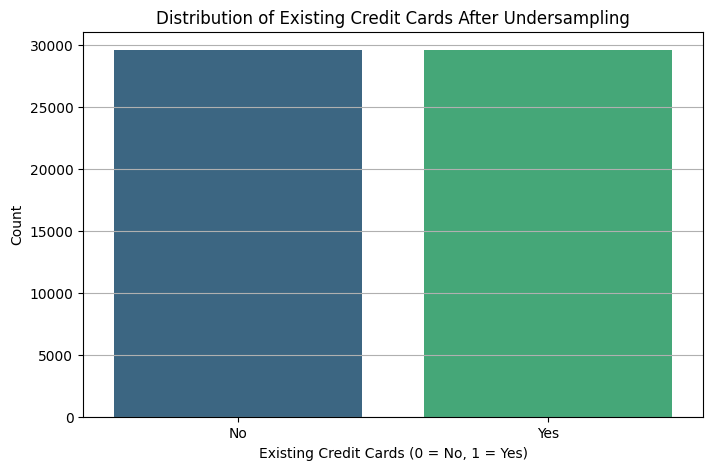

In [18]:

from imblearn.under_sampling import RandomUnderSampler

# Handling Existing_Credit_Cards
df['Existing_Credit_Cards'] = df['Existing_Credit_Cards'].apply(lambda x: 0 if x == 0 else 1)

# Print the value counts before undersampling
print("Value counts before undersampling:")
print(df['Existing_Credit_Cards'].value_counts())

# Prepare data for undersampling
X = df.drop(columns='Existing_Credit_Cards')  
y = df['Existing_Credit_Cards']                

# Undersample the majority class
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Combine the resampled data back into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Existing_Credit_Cards'] = y_resampled

# Get the value counts after undersampling
value_counts_resampled = df_resampled['Existing_Credit_Cards'].value_counts()

# Plotting the distribution after undersampling
plt.figure(figsize=(8, 5))
sns.barplot(x=value_counts_resampled.index, y=value_counts_resampled.values, palette='viridis')
plt.title('Distribution of Existing Credit Cards After Undersampling')
plt.xlabel('Existing Credit Cards (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(ticks=value_counts_resampled.index, labels=['No', 'Yes'])
plt.grid(axis='y')
plt.show()


In [19]:
import pandas as pd

# Display original value counts for verification
print("Original value counts:")
print(df['Occupation'].value_counts())

# Combine 'Entrepreneur' with 'Other'
df['Occupation'] = df['Occupation'].replace({'Entrepreneur': 'Other'})

# Display updated value counts to verify the change
print("\nUpdated value counts after combining 'Entrepreneur' with 'Other':")
print(df['Occupation'].value_counts())


Original value counts:
Occupation
Self_Employed    34941
Salaried         27649
Other            24927
Entrepreneur       626
Name: count, dtype: int64

Updated value counts after combining 'Entrepreneur' with 'Other':
Occupation
Self_Employed    34941
Salaried         27649
Other            25553
Name: count, dtype: int64


In [20]:
print("\nStatistical summary of the dataset")
df.describe()


Statistical summary of the dataset


,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Tenure_with_Bank
count,88143.000000,88143.000000,88143.000000,88143.000000,8.814300e+04,88143.000000
mean,100736.196068,42.835710,598.672952,0.335965,1.122263e+06,7.328273
std,45184.678330,14.893035,179.940523,0.472330,8.656068e+05,5.148385
min,42820.000000,24.000000,300.000000,0.000000,2.259700e+04,1.000000
25%,64230.000000,29.000000,441.000000,0.000000,5.951250e+05,3.000000
50%,94725.000000,41.000000,583.000000,0.000000,8.833420e+05,10.000000
75%,115775.000000,53.000000,767.000000,1.000000,1.355884e+06,10.000000
max,210500.000000,85.000000,900.000000,1.000000,9.908858e+06,15.000000


In [21]:
print(df.columns)

Index(['Gender', 'Month_Income', 'Age', 'Occupation', 'Credit_Score',
       'Loan_Status', 'Existing_Credit_Cards', 'Avg_Account_Balance',
       'Account_Category', 'Tenure_with_Bank', 'Lead_Outcome'],
      dtype='object')


In [22]:
df['Lead_Outcome']=df['Lead_Outcome'].apply(lambda x : 1 if x=='Yes' else 0) 


In [23]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Gender','Occupation', 'Loan_Status', 'Account_Category']

encoder = OneHotEncoder( sparse_output=False)  

encoded_columns = encoder.fit_transform(df[categorical_columns])

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

df_final = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

print(df_final.head())




   Month_Income   Age  Credit_Score  Existing_Credit_Cards  \
0       96345.0  29.0         623.0                    1.0   
2       96345.0  31.0         357.0                    0.0   
3       85640.0  29.0         356.0                    0.0   
4       42820.0  29.0         572.0                    0.0   
5       64230.0  60.0         478.0                    0.0   

   Avg_Account_Balance  Tenure_with_Bank  Lead_Outcome  Gender_Female  \
0             742366.0               2.0           0.0            0.0   
2             215949.0               1.0           0.0            0.0   
3             868070.0               3.0           0.0            1.0   
4             657087.0               3.0           0.0            0.0   
5            4624262.0              10.0           0.0            1.0   

   Gender_Male  Occupation_Other  Occupation_Salaried  \
0          1.0               1.0                  0.0   
2          1.0               1.0                  0.0   
3          0.0   

In [24]:
df_final.head()

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Tenure_with_Bank,Lead_Outcome,Gender_Female,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Loan_Status_No,Loan_Status_Yes,Account_Category_Current Account,Account_Category_Investment Account,Account_Category_Savings Account,Account_Category_Senior Citizens Account
0,96345.0,29.0,623.0,1.0,742366.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,96345.0,31.0,357.0,0.0,215949.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,85640.0,29.0,356.0,0.0,868070.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,42820.0,29.0,572.0,0.0,657087.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,64230.0,60.0,478.0,0.0,4624262.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [25]:
print("Missing values in df_final:", pd.isnull(df_final).sum())


Missing values in df_final: Month_Income                                14121
Age                                         14121
Credit_Score                                14121
Existing_Credit_Cards                       14121
Avg_Account_Balance                         14121
Tenure_with_Bank                            14121
Lead_Outcome                                14121
Gender_Female                               14121
Gender_Male                                 14121
Occupation_Other                            14121
Occupation_Salaried                         14121
Occupation_Self_Employed                    14121
Loan_Status_No                              14121
Loan_Status_Yes                             14121
Account_Category_Current Account            14121
Account_Category_Investment Account         14121
Account_Category_Savings Account            14121
Account_Category_Senior Citizens Account    14121
dtype: int64


In [26]:
df_final.dropna(inplace=True)


In [27]:
print(df_final.isnull().sum())


Month_Income                                0
Age                                         0
Credit_Score                                0
Existing_Credit_Cards                       0
Avg_Account_Balance                         0
Tenure_with_Bank                            0
Lead_Outcome                                0
Gender_Female                               0
Gender_Male                                 0
Occupation_Other                            0
Occupation_Salaried                         0
Occupation_Self_Employed                    0
Loan_Status_No                              0
Loan_Status_Yes                             0
Account_Category_Current Account            0
Account_Category_Investment Account         0
Account_Category_Savings Account            0
Account_Category_Senior Citizens Account    0
dtype: int64


In [28]:
X = df_final.drop('Lead_Outcome', axis=1)
y = df_final['Lead_Outcome']

In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [30]:
#check each model accuracy one by one
def model_acc(model):
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(str(model)+ ' --> ' +str(acc))

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


c:\Users\Gen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() --> 0.7096411041563471
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.68      0.74     13712
         1.0       0.60      0.75      0.66      8495

    accuracy                           0.71     22207
   macro avg       0.71      0.72      0.70     22207
weighted avg       0.73      0.71      0.71     22207



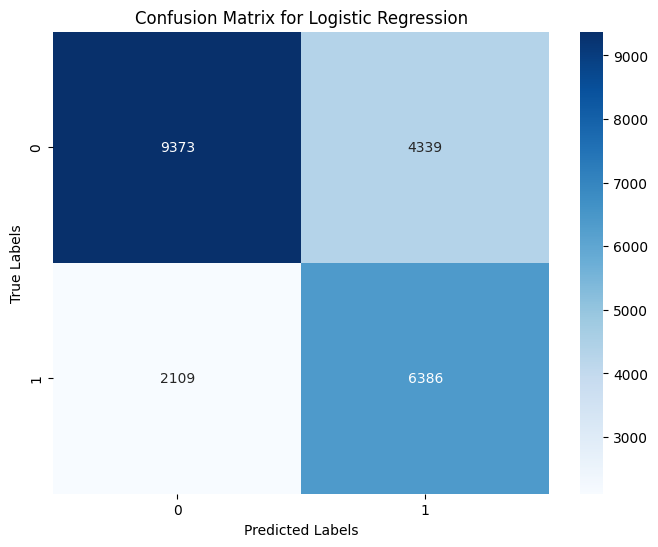

In [47]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
model_acc(log)

# Predict on test set
y_pred = log.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

KNeighborsClassifier() --> 0.9308776511910659
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.95     13712
         1.0       0.97      0.85      0.90      8495

    accuracy                           0.93     22207
   macro avg       0.94      0.91      0.92     22207
weighted avg       0.93      0.93      0.93     22207



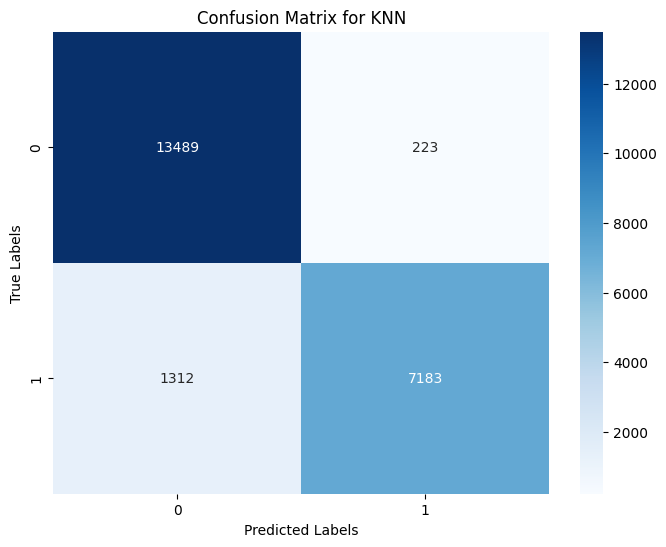

In [43]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier()
model_acc(kn)

# Predict on test set
y_pred = kn.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



SVC() --> 0.8747241860674562
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     13712
         1.0       1.00      0.67      0.80      8495

    accuracy                           0.87     22207
   macro avg       0.92      0.84      0.86     22207
weighted avg       0.90      0.87      0.87     22207



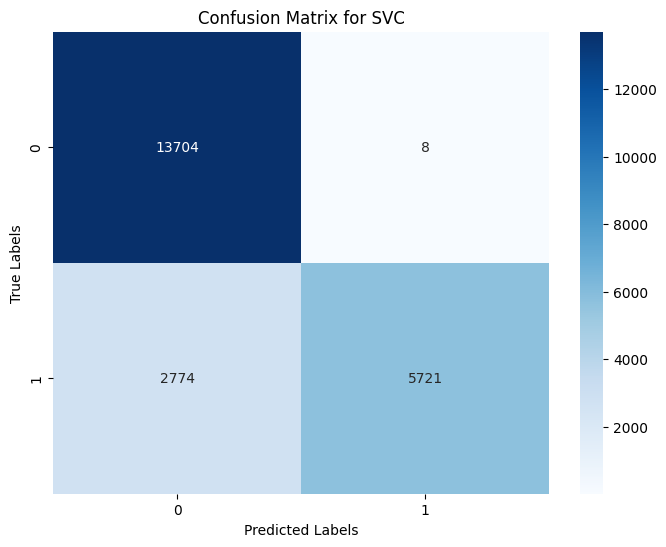

In [48]:
from sklearn.svm import SVC
svc_m = SVC()
model_acc(svc_m)

# Predict on test set
y_pred = svc_m.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
 
 

In [34]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
model_acc(classifier)

GaussianNB() --> 0.9950466069257441


MLPClassifier() --> 0.5839149817625073
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.33      0.49     13712
         1.0       0.48      1.00      0.65      8495

    accuracy                           0.58     22207
   macro avg       0.73      0.66      0.57     22207
weighted avg       0.79      0.58      0.55     22207



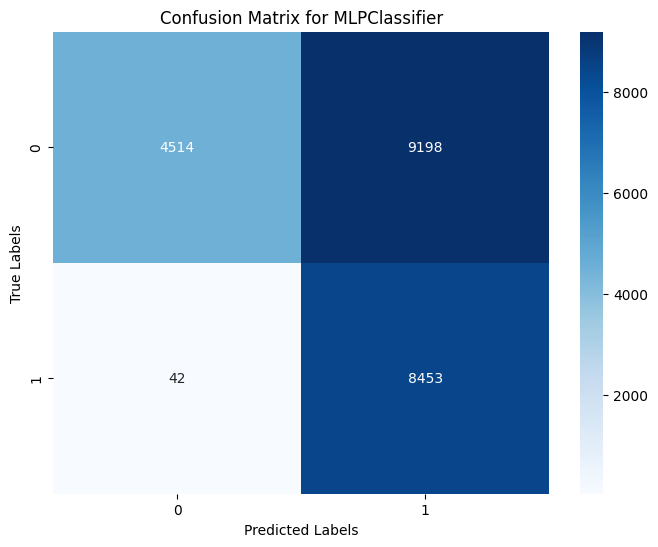

In [49]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
model_acc(mlp)

# Predict on test set
y_pred = mlp.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for MLPClassifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [36]:
# # Parameter grid for KNN
# param_grid_knn = {
#     'n_neighbors': [3, 5, 7, 10],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree'],
#     'leaf_size': [10, 20, 30]  
# }


# # Parameter grid for Logistic Regression
# param_grid_lr = {
#     'C': [0.01, 0.1, 1, 10],
#     'penalty': ['l2'],
#     'solver': ['lbfgs', 'liblinear']
# }

# # Parameter grid for MLP
# param_grid_mlp = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  
#     'activation': ['relu', 'logistic'],
#     'solver': ['adam', 'sgd'],
#     'alpha': [ 0.001, 0.01],  
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
#     'max_iter': [200, 300]
# }



# # Initialize models
# models = {
#     'KNN': (KNeighborsClassifier(), param_grid_knn, GridSearchCV),
#     'Logistic Regression': (LogisticRegression(class_weight='balanced'), param_grid_lr, GridSearchCV),
#     'MLPClassifier': (MLPClassifier(), param_grid_mlp, RandomizedSearchCV),
#     'SVC': (SVC(), param_grid_knn, GridSearchCV),

    
# }

In [37]:
# # Perform hyperparameter tuning with K-Fold Cross Validation
# best_models = {}

# for name, (model, param_grid, search_method) in models.items():
#     print("-" * 100)
#     print(f"Starting hyperparameter tuning for {name}...")
    
#     # For GridSearchCV or RandomizedSearchCV based on the model
#     if search_method == GridSearchCV:
#         grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2)
#     else:
#         grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=kfold, n_jobs=-1, verbose=2, random_state=42)
    
#     grid_search.fit(X_train, y_train)
    
#     print(f"Best parameters for {name}: {grid_search.best_params_}")
#     print(f"Best score for {name}: {grid_search.best_score_}")
#     print("-" * 100)
    
#     best_models[name] = grid_search.best_estimator_

In [38]:
# # Evaluate the tuned models
# def evaluate_models(models, X_test, y_test):
#     for name, model in models.items():
#         print(f'\nPerformance Report for {name} (Tuned):\n')
        
#         # Predict the outcomes
#         y_pred = model.predict(X_test)
        
#         # Compute and print accuracy
#         accuracy = accuracy_score(y_test, y_pred)
#         print(f'Accuracy: {accuracy:.4f}')

#         # Compute and print classification report
#         print('Classification Report:')
#         print(classification_report(y_test, y_pred))

# # Call the function to evaluate the best models
# evaluate_models(best_models, X_test, y_test)

In [39]:
predicted = kn.predict(X_test)

In [40]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# # Compute confusion matrix
# cm = confusion_matrix(y_test, predicted)

# # Function to plot confusion matrix
# def plot_confusion_matrix(cm, labels):
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
#                 xticklabels=labels, yticklabels=labels)
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.title('Confusion Matrix')
#     plt.show()

# labels = ['Class 0', 'Class 1']  
# plot_confusion_matrix(cm, labels)
